# 인터넷 서비스 유형에 따른 고객 이탈 원인 분석 및 이탈 방지 전략 제안

In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_csv("통신사고객이탈\data\cust_data_v1.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7034 non-null   object 
 2   SeniorCitizen     7042 non-null   float64
 3   Partner           7043 non-null   object 
 4   Dependents        7041 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7040 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  3580 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7042 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [1]:
df.describe()

NameError: name 'df' is not defined

In [12]:
DATA_PATH = "cust_data_v1.csv"
OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
TAB_DIR = os.path.join(OUT_DIR, "tables")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)


In [4]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,NaN,0.0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,NaN,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0.0,No,No,2,Yes,No,DSL,Yes,...,NaN,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45,No,No phone service,DSL,Yes,...,NaN,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2,Yes,No,Fiber optic,No,...,NaN,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0.0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0.0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0.0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1.0,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,NaN,0.0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


# 결측치 확인 및 처리

In [49]:
# 1) 공백/문자열 정리: "   " 같은 공백을 NaN으로
#    (객체형 컬럼 전체에 적용)
obj_cols = df.select_dtypes(include="object").columns
for c in obj_cols:
    df[c] = df[c].replace(r"^\s*$", np.nan, regex=True)  # 공백만 있는 문자열 -> NaN
    df[c] = df[c].astype("string").str.strip()           # 양쪽 공백 제거

# 2) 결측률 리포트(전처리 전)
missing_before = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
missing_before.head(15)

# 3) TotalCharges 수치형 변환 (변환 실패 -> NaN)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# 4) 인터넷 기반 컬럼: InternetService=No면 "No internet service"로 복원, 나머지 결측은 "Unknown"
internet_dependent_cols = [
    "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies"
]

# 혹시 컬럼명이 데이터에 없을 수도 있으니 안전하게 실제 존재하는 컬럼만
internet_dependent_cols = [c for c in internet_dependent_cols if c in df.columns]

# (A) InternetService=No -> "No internet service"
for c in internet_dependent_cols:
    df.loc[df["InternetService"] == "No", c] = "No internet service"

# (B) 그 외 결측 -> "Unknown"
for c in internet_dependent_cols:
    df[c] = df[c].fillna("Unknown")

# 5) 나머지 범주형 결측 -> 최빈값으로 대체 (원하면 일부만 선택해도 됨)
#    (단, 'customerID' 같은 식별자 컬럼은 건드리지 않는 게 안전)
categorical_cols = df.select_dtypes(include=["string", "object"]).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != "customerID"]

for c in categorical_cols:
    if df[c].isna().any():
        mode_val = df[c].mode(dropna=True)
        if len(mode_val) > 0:
            df[c] = df[c].fillna(mode_val[0])

# 6) 수치형 결측 -> 중앙값으로 대체
numeric_cols = df.select_dtypes(include=["number"]).columns
for c in numeric_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# 7) 결측률 리포트(전처리 후)
missing_after = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
missing_after.head(15)

customerID          0.0
gender              0.0
Churn               0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Contract            0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
DeviceProtection    0.0
OnlineBackup        0.0
OnlineSecurity      0.0
InternetService     0.0
dtype: float64

In [50]:
# (1) InternetService=No인데 인터넷 기반 컬럼이 Unknown으로 남아있진 않은지 확인
if len(internet_dependent_cols) > 0:
    check = df[df["InternetService"]=="No"][internet_dependent_cols].apply(lambda s: (s=="Unknown").mean()).sort_values(ascending=False)
    print("InternetService=No에서 'Unknown' 비율(각 컬럼):")
    print(check)

# (2) TotalCharges 변환 결과 확인
print(df["TotalCharges"].dtype, df["TotalCharges"].isna().sum())

# (3) 전체 결측치가 남아있는지
print("전체 결측치 개수:", int(df.isna().sum().sum()))

InternetService=No에서 'Unknown' 비율(각 컬럼):
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64
Float64 0
전체 결측치 개수: 0


# 분석 목표

1. 목적: 
인터넷 서비스 유형(DSL, Fiber optic 등)이 고객 이탈에 미치는 영향을 분석하여 핵심 이탈 원인을 규명하고자 함

2. 배경: 
통신 시장의 포화로 신규 고객 유치 비용이 증가함에 따라, 기존 고객의 이탈(Churn) 관리가 중요함

3. 필요성: 
인터넷 서비스 이용자들의 월평균 요금이 인터넷 서비스 비이용자들의 월평균 요금보다 높기 때문에 인터넷 서비스 이용자들의 이탈 원인을 살펴봐야 함

또한 서비스 유형별로 고객이 느끼는 가치와 불편사항이 다르므로, 획일적인 방안이 아닌 데이터 기반의 맞춤형 이탈 방지 전략이 필요함


# 인터넷 서비스 이용 유무의 비율과 평균 요금 

In [35]:
#인터넷 서비스 이용 유무의 비율과 평균 요금 

df["InternetService"] = df["InternetService"].astype(str).str.strip()
df["PhoneService"] = df["PhoneService"].astype(str).str.strip()

# 2) InternetService = "No" 인원/비율
no_mask = df["InternetService"] == "No"
no_count = int(no_mask.sum())
total_count = len(df)
no_ratio = no_count / total_count

print(f"[InternetService=No] 인원: {no_count} / {total_count} ({no_ratio:.2%})")

# 3) InternetService = "No" 평균 월요금(MonthlyCharges)
no_avg_monthly = df.loc[no_mask, "MonthlyCharges"].mean()
print(f"[InternetService=No] 평균 월요금(MonthlyCharges): {no_avg_monthly:.2f}")

# 4) InternetService != "No" (인터넷 이용자: DSL/Fiber) 평균 월요금
yes_mask = df["InternetService"] != "No"
yes_avg_monthly = df.loc[yes_mask, "MonthlyCharges"].mean()
print(f"[InternetService!=No] 평균 월요금(MonthlyCharges): {yes_avg_monthly:.2f}")

# (참고) DSL/Fiber 각각 평균 월요금도 같이 보고 싶으면
avg_by_type = df.loc[yes_mask].groupby("InternetService")["MonthlyCharges"].mean().round(2)
print("\n[참고] InternetService 유형별 평균 월요금")
print(avg_by_type)

# 5) InternetService=No 중 PhoneService 이용 비율
no_phone_ratio = (df.loc[no_mask, "PhoneService"] == "Yes").mean()
print(f"\n[InternetService=No] 중 PhoneService=Yes 비율: {no_phone_ratio:.2%}")

# (참고) InternetService=No 중 PhoneService 분포
no_phone_dist = df.loc[no_mask, "PhoneService"].value_counts(dropna=False)
print("\n[참고] InternetService=No 중 PhoneService 분포")
print(no_phone_dist)

[InternetService=No] 인원: 1526 / 7043 (21.67%)
[InternetService=No] 평균 월요금(MonthlyCharges): 21.08
[InternetService!=No] 평균 월요금(MonthlyCharges): 76.85

[참고] InternetService 유형별 평균 월요금
InternetService
DSL            58.1
Fiber optic    91.5
Name: MonthlyCharges, dtype: float64

[InternetService=No] 중 PhoneService=Yes 비율: 100.00%

[참고] InternetService=No 중 PhoneService 분포
PhoneService
Yes    1526
Name: count, dtype: int64


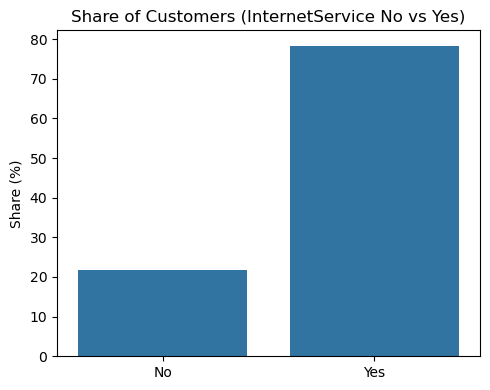

In [38]:
# InternetService No vs Yes 비율 막대그래프

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.barplot(data=summary, x="InternetYN", y="share")
plt.title("Share of Customers (InternetService No vs Yes)")
plt.ylabel("Share (%)")
plt.xlabel("")
plt.tight_layout()
plt.show()

인터넷 서비스 사용자수 비율은 78.3%, 인터넷 서비스 비사용자수 비율은 21.7%이다.

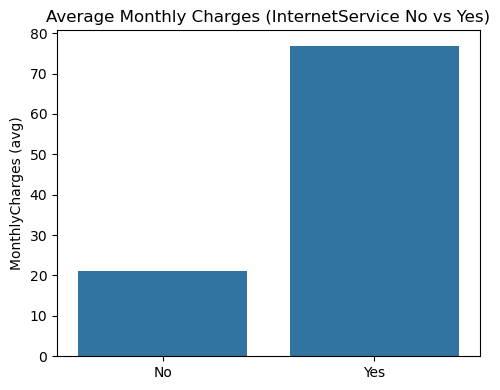

In [44]:
#평균 월요금 비교 막대그래프

plt.figure(figsize=(5,4))
sns.barplot(data=summary, x="InternetYN", y="avg_monthly")
plt.title("Average Monthly Charges (InternetService No vs Yes)")
plt.ylabel("MonthlyCharges (avg)")
plt.xlabel("")


plt.tight_layout()
plt.show()

인터넷 서비스 사용 유무에 따른 월평균 금액을 비교한 그래프이다. 
인터넷 서비스 사용자의 월평균 금액은 76.85이고, 인터넷 서비스 비사용자의 월평균 금액은 21.08이다.

In [37]:
# 인터넷 여부(Yes=DSL/Fiber, No=No)
df["InternetYN"] = np.where(df["InternetService"] == "No", "No", "Yes")

# 요약 테이블 만들기
summary = (
    df.groupby("InternetYN")
      .agg(
          n=("InternetYN", "size"),
          avg_monthly=("MonthlyCharges", "mean"),
          phone_yes_rate=("PhoneService", lambda s: (s == "Yes").mean())
      )
      .reset_index()
)

summary["share"] = summary["n"] / summary["n"].sum()
summary["avg_monthly"] = summary["avg_monthly"].round(2)
summary["phone_yes_rate"] = (summary["phone_yes_rate"] * 100).round(1)
summary["share"] = (summary["share"] * 100).round(1)

summary

,InternetYN,n,avg_monthly,phone_yes_rate,share
0,No,1526,21.08,100.0,21.7
1,Yes,5517,76.85,87.6,78.3


# 인터넷 서비스 별 비교 - Fiber vs DSL

In [15]:
#Fiber vs DSL 이탈률(전체)
overall = (
    df_if.groupby("InternetService")["ChurnFlag"]
    .agg(n="count", churn_rate="mean")
    .reset_index()
)

overall["churn_rate"] = (overall["churn_rate"] * 100).round(1)
overall.to_csv(os.path.join(TAB_DIR, "churn_by_internetservice.csv"), index=False, encoding="utf-8-sig")
print("\n=== Churn rate by InternetService ===")
print(overall)


=== Churn rate by InternetService ===
  InternetService     n  churn_rate
0             DSL  2419        19.0
1     Fiber optic  3096        41.9


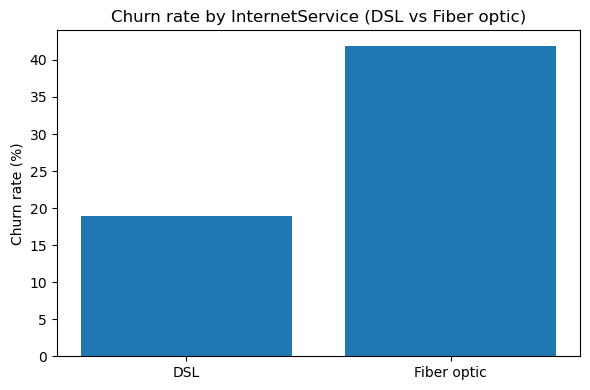

In [28]:
# 막대그래프 저장
plt.figure(figsize=(6, 4))
plt.bar(overall["InternetService"], overall["churn_rate"])
plt.title("Churn rate by InternetService (DSL vs Fiber optic)")
plt.ylabel("Churn rate (%)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "churn_by_internetservice.png"), dpi=200)


DSL 서비스를 이용하는 고객의 총 이탈률은 19%, Fiber optic 서비스를 이용하는 고객의 이탈률은 41.9%로, 모두 이탈률을 감소시키기 위한 방안을 모색해야 한다.

In [ ]:
# Contract로 통제: 계약별 Fiber vs DSL 이탈률

by_contract = (
    df_if.groupby(["Contract", "InternetService"])["ChurnFlag"]
    .agg(n="count", churn_rate="mean")
    .reset_index()
)
by_contract["churn_rate"] = (by_contract["churn_rate"] * 100).round(1)
by_contract.to_csv(os.path.join(TAB_DIR, "churn_by_contract_and_internetservice.csv"), index=False, encoding="utf-8-sig")
print("\n=== Churn rate by Contract & InternetService ===")
print(by_contract.sort_values(["Contract", "InternetService"]))


=== Churn rate by Contract & InternetService ===
         Contract InternetService     n  churn_rate
0  Month-to-month             DSL  1221        32.3
1  Month-to-month     Fiber optic  2128        54.6
2        One year             DSL   570         9.3
3        One year     Fiber optic   539        19.3
4        Two year             DSL   628         1.9
5        Two year     Fiber optic   429         7.2


In [19]:
# 계약별 막대그래프(간단히 한 그림에)
contracts = ["Month-to-month", "One year", "Two year"]
plt.figure(figsize=(8, 4))

x = np.arange(len(contracts))
width = 0.35

dsl_rates = []
fiber_rates = []

for c in contracts:
    dsl = by_contract[(by_contract["Contract"] == c) & (by_contract["InternetService"] == "DSL")]
    fib = by_contract[(by_contract["Contract"] == c) & (by_contract["InternetService"] == "Fiber optic")]
    dsl_rates.append(float(dsl["churn_rate"].iloc[0]) if len(dsl) else np.nan)
    fiber_rates.append(float(fib["churn_rate"].iloc[0]) if len(fib) else np.nan)



<Figure size 800x400 with 0 Axes>

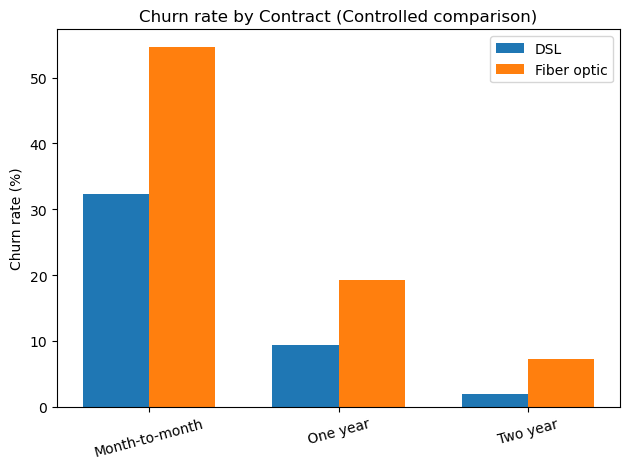

In [27]:
plt.bar(x - width/2, dsl_rates, width, label="DSL")
plt.bar(x + width/2, fiber_rates, width, label="Fiber optic")
plt.xticks(x, contracts, rotation=15)
plt.ylabel("Churn rate (%)")
plt.title("Churn rate by Contract (Controlled comparison)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "churn_by_contract_controlled.png"), dpi=200)


계약 유형에 따른 이탈률을 비교해 보았다. 전체적으로 계약기간이 길 때 이탈률이 낮다는 것을 알 수 있다.

In [ ]:
#월요금 분포 비교: Fiber vs DSL

charges_desc = (
    df_if.groupby("InternetService")["MonthlyCharges"]
    .describe()[["count", "mean", "50%", "25%", "75%", "min", "max"]]
    .round(2)
    .reset_index()
)
charges_desc.to_csv(os.path.join(TAB_DIR, "monthlycharges_desc_by_internetservice.csv"), index=False, encoding="utf-8-sig")
print("\n=== MonthlyCharges summary (DSL vs Fiber) ===")
print(charges_desc)



=== MonthlyCharges summary (DSL vs Fiber) ===
  InternetService   count   mean    50%    25%     75%    min     max
0             DSL  2419.0  58.12  56.15  46.20   69.90  23.45   94.80
1     Fiber optic  3096.0  91.50  91.68  80.55  101.15  67.75  118.75


C:\Users\Admin\AppData\Local\Temp\ipykernel_10408\3515251692.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["DSL", "Fiber optic"])


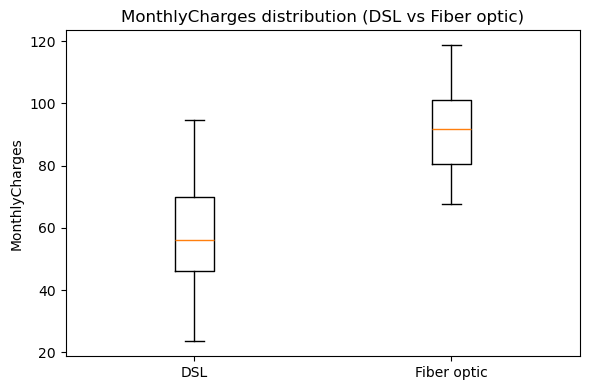

In [32]:

# 박스플롯 (분포 비교)
plt.figure(figsize=(6, 4))
data = [
    df_if[df_if["InternetService"] == "DSL"]["MonthlyCharges"],
    df_if[df_if["InternetService"] == "Fiber optic"]["MonthlyCharges"],
]
plt.boxplot(data, labels=["DSL", "Fiber optic"])
plt.title("MonthlyCharges distribution (DSL vs Fiber optic)")
plt.ylabel("MonthlyCharges")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "monthlycharges_boxplot.png"), dpi=200)


In [42]:
import plotly.express as px

avg_by_type = df.loc[yes_mask].groupby("InternetService")["MonthlyCharges"].mean().round(2)

avg_df = avg_by_type.reset_index()
avg_df.columns = ["InternetService", "AvgMonthlyCharges"]

fig = px.bar(
    avg_df,
    x="InternetService",
    y="AvgMonthlyCharges",
    text="AvgMonthlyCharges",
    title="Average MonthlyCharges by InternetService (DSL vs Fiber optic)"
)
fig.update_traces(textposition="outside")
fig.update_yaxes(title="Avg MonthlyCharges")
fig.update_layout(xaxis_title="", uniformtext_minsize=10, uniformtext_mode="hide")
fig.show()

In [ ]:
또한, 인터넷 서비스 유형 별 월 평균 금액은 다음과 같다.
DSL            58.1
Fiber optic    91.5

따라서 Fiber optic의 이탈 원인을 해소하는 것이 더욱 중요하다.

In [48]:
# 6) Fiber 초기(0–6개월) 집중 분석

def churn_rate(sub_df):
    return (sub_df["ChurnFlag"].mean() * 100).round(1), len(sub_df)

fiber = df_if[df_if["InternetService"] == "Fiber optic"].copy()
dsl = df_if[df_if["InternetService"] == "DSL"].copy()

fiber_0_6 = fiber[fiber["tenure"].between(0, 6)]
dsl_0_6 = dsl[dsl["tenure"].between(0, 6)]

fiber_rate_0_6, fiber_n_0_6 = churn_rate(fiber_0_6)
dsl_rate_0_6, dsl_n_0_6 = churn_rate(dsl_0_6)

churn_rate(fiber_0_6), churn_rate(dsl_0_6)

((74.2, 620), (48.3, 509))

In [66]:
# 같은 조건(월단위 & 0–6개월)로도 비교
fiber_mm_0_6 = fiber[(fiber["Contract"] == "Month-to-month") & (fiber["tenure"].between(0, 6))]
dsl_mm_0_6 = dsl[(dsl["Contract"] == "Month-to-month") & (dsl["tenure"].between(0, 6))]

fiber_mm_rate, fiber_mm_n = churn_rate(fiber_mm_0_6)
dsl_mm_rate, dsl_mm_n = churn_rate(dsl_mm_0_6)

initial_tbl = pd.DataFrame([
    {"segment": "Fiber optic (tenure 0-6)", "n": fiber_n_0_6, "churn_rate_%": fiber_rate_0_6},
    {"segment": "DSL (tenure 0-6)", "n": dsl_n_0_6, "churn_rate_%": dsl_rate_0_6},
    {"segment": "Fiber optic (Month-to-month & tenure 0-6)", "n": fiber_mm_n, "churn_rate_%": fiber_mm_rate},
    {"segment": "DSL (Month-to-month & tenure 0-6)", "n": dsl_mm_n, "churn_rate_%": dsl_mm_rate},
])

initial_tbl.to_csv(os.path.join(TAB_DIR, "fiber_initial_churn_analysis.csv"), index=False, encoding="utf-8-sig")
print("\n=== Initial churn focus (0-6 months) ===")
print(initial_tbl)


=== Initial churn focus (0-6 months) ===
                                     segment    n  churn_rate_%
0                   Fiber optic (tenure 0-6)  620          74.2
1                           DSL (tenure 0-6)  509          48.3
2  Fiber optic (Month-to-month & tenure 0-6)  619          74.2
3          DSL (Month-to-month & tenure 0-6)  494          49.6


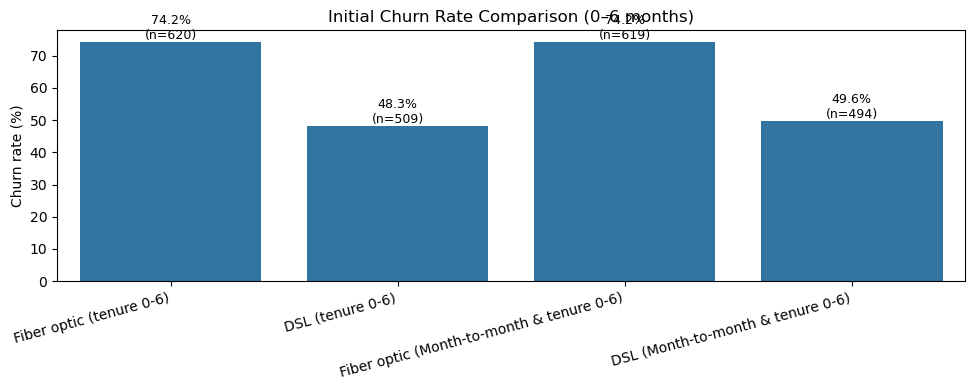

In [65]:
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=initial_tbl, x="segment", y="churn_rate_%")

ax.set_title("Initial Churn Rate Comparison (0–6 months)")
ax.set_xlabel("")
ax.set_ylabel("Churn rate (%)")

# x축 라벨 길어서 보기 좋게
plt.xticks(rotation=15, ha="right")

# ✅ 막대 위에 "xx.x% (n=xxx)" 라벨 붙이기
for p, n in zip(ax.patches, initial_tbl["n"]):
    value = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2,
        value,
        f"{value:.1f}%\n(n={int(n)})",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [ ]:
초기 고객 이탈 위험군인 0~6개월 고객, 월별 계약의 이탈률이 제일 높다는 것을 알 수 있다.

In [51]:
df["ChurnFlag"] = df["Churn"].map({"Yes":1,"No":0})

fiber = df[df["InternetService"]=="Fiber optic"].copy()
long = fiber[fiber["tenure"]>=49].copy()

keep = long[long["Churn"]=="No"]
churn = long[long["Churn"]=="Yes"]

def yes_rate(d, col): 
    return (d[col]=="Yes").mean()

# 서비스 가입률 비교
for col in ["TechSupport","OnlineSecurity","StreamingTV","StreamingMovies"]:
    print(col, yes_rate(keep,col), yes_rate(churn,col))

# 계약/결제 분포
print(pd.crosstab(long["Churn"], long["Contract"], normalize="index"))
print(pd.crosstab(long["Churn"], long["PaymentMethod"], normalize="index"))

TechSupport 0.5172413793103449 0.3179190751445087
OnlineSecurity 0.5160523186682521 0.3063583815028902
StreamingTV 0.7253269916765755 0.8439306358381503
StreamingMovies 0.7443519619500595 0.8208092485549133
Contract  Month-to-month  One year  Two year
Churn                                       
No              0.223543  0.342449  0.434007
Yes             0.450867  0.387283  0.161850
PaymentMethod  Bank transfer (automatic)  Credit card (automatic)  Electronic check  Mailed check
Churn                                                                                            
No                              0.325803                 0.316290          0.305589      0.052319
Yes                             0.260116                 0.219653          0.514451      0.005780


In [54]:
# 공백/빈문자 -> NaN, 양끝 공백 제거 (범주형 안정화)
obj_cols = df.select_dtypes(include="object").columns
for c in obj_cols:
    df[c] = df[c].replace(r"^\s*$", np.nan, regex=True)
    df[c] = df[c].astype("string").str.strip()

# ChurnFlag 만들기(원하면)
df["ChurnFlag"] = df["Churn"].map({"Yes": 1, "No": 0})





In [55]:
LONG_TENURE = 24  

fiber_long = df[(df["InternetService"] == "Fiber optic") & (df["tenure"] >= LONG_TENURE)].copy()

keep = fiber_long[fiber_long["Churn"] == "No"].copy()
churn = fiber_long[fiber_long["Churn"] == "Yes"].copy()

print("Fiber long total:", len(fiber_long))
print("Keep (Churn=No):", len(keep))
print("Churn (Churn=Yes):", len(churn))

Fiber long total: 1760
Keep (Churn=No): 1310
Churn (Churn=Yes): 450


In [56]:
contract_rate = pd.crosstab(
    fiber_long["Churn"],
    fiber_long["Contract"],
    normalize="index"
) * 100

contract_rate = contract_rate.round(1)
contract_rate

print("[Contract % within each Churn group]")
print("Keep (No):")
print(contract_rate.loc["No"].to_dict())
print("\nChurn (Yes):")
print(contract_rate.loc["Yes"].to_dict())

[Contract % within each Churn group]
Keep (No):
{'Month-to-month': 38.2, 'One year': 31.5, 'Two year': 30.4}

Churn (Yes):
{'Month-to-month': 71.3, 'One year': 21.8, 'Two year': 6.9}


In [57]:
pay_rate = pd.crosstab(
    fiber_long["Churn"],
    fiber_long["PaymentMethod"],
    normalize="index"
) * 100

pay_rate = pay_rate.round(1)
pay_rate

PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
Churn,,,,
No,30.1,28.7,35.5,5.7
Yes,20.2,18.0,57.8,4.0


In [61]:
# fiber 장기 고객의 서비스 가입률 (24개월 이상)

In [58]:
def yes_rate(d, col):
    # 값이 'Yes'인 비율(%) 계산
    return round((d[col] == "Yes").mean() * 100, 1)

service_cols = ["TechSupport", "OnlineSecurity", "StreamingTV", "StreamingMovies"]

result = []
for col in service_cols:
    if col in fiber_long.columns:
        result.append({
            "Feature": col,
            "Keep_YesRate(%)": yes_rate(keep, col),
            "Churn_YesRate(%)": yes_rate(churn, col),
        })

service_compare = pd.DataFrame(result)
service_compare

,Feature,Keep_YesRate(%),Churn_YesRate(%)
0,TechSupport,45.1,24.7
1,OnlineSecurity,43.6,23.1
2,StreamingTV,67.6,71.1
3,StreamingMovies,68.4,71.6


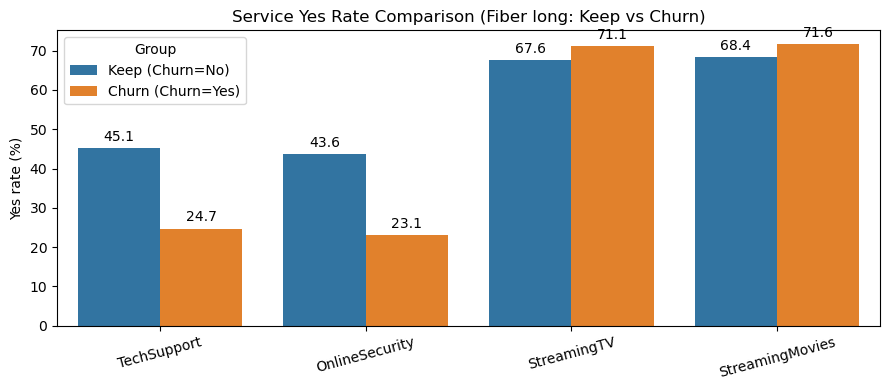

In [64]:
# 1) long format으로 변환(그룹 막대그래프용)
plot_df = service_compare.melt(
    id_vars="Feature",
    value_vars=["Keep_YesRate(%)", "Churn_YesRate(%)"],
    var_name="Group",
    value_name="YesRate"
)

plot_df["Group"] = plot_df["Group"].replace({
    "Keep_YesRate(%)": "Keep (Churn=No)",
    "Churn_YesRate(%)": "Churn (Churn=Yes)"
})

# 2) plot
plt.figure(figsize=(9, 4))
ax = sns.barplot(data=plot_df, x="Feature", y="YesRate", hue="Group")

ax.set_title("Service Yes Rate Comparison (Fiber long: Keep vs Churn)")
ax.set_xlabel("")
ax.set_ylabel("Yes rate (%)")

# 3) 막대 위 숫자 라벨
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=3)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

계약 유지 고객과 이탈 고객의 차이를 봤을 때, 

Keep_YesRate가 더 큰 요인들은 유지 고객에게 더욱 어필이 되는 점이라고 볼 수 있다.  => TechSupport와 OnlineSecurity

Churn_YesRate가 더 큰 요인들은 그 서비스를 쓰는 고객군이 불만을 더 크게 느낄 수 있는 분야이다.

하지만 StreamingTV와 StreamingMovies는 모두 비율이 높기 때문에 약간의 개선들이 필요한 것으로 보인다.

# fiber 단기 고객(0~6개월)의 서비스 가입률

In [60]:
# 공백 정리(안전)
obj_cols = df.select_dtypes(include="object").columns
for c in obj_cols:
    df[c] = df[c].replace(r"^\s*$", np.nan, regex=True)
    df[c] = df[c].astype("string").str.strip()

# Fiber + 단기(0~6개월) 필터
fiber_short = df[(df["InternetService"] == "Fiber optic") & (df["tenure"].between(0, 6))].copy()

print("Fiber short (0-6) n =", len(fiber_short))

# Yes 비율 계산 함수
def yes_rate(d, col):
    return round((d[col] == "Yes").mean() * 100, 1)

# 전체(단기 Fiber 전체)에서 가입률
tech_rate = yes_rate(fiber_short, "TechSupport")
sec_rate  = yes_rate(fiber_short, "OnlineSecurity")

print(f"TechSupport Yes rate (%): {tech_rate}")
print(f"OnlineSecurity Yes rate (%): {sec_rate}")

fiber_short = df[(df["InternetService"] == "Fiber optic") & (df["tenure"].between(0, 6))].copy()
print("Fiber short (0-6) n =", len(fiber_short))


features = ["TechSupport", "OnlineSecurity", "StreamingTV", "StreamingMovies"]

overall_rates = pd.DataFrame([{
    "Feature": col,
    "YesRate(%)": yes_rate(fiber_short, col)
} for col in features])

overall_rates

Fiber short (0-6) n = 620
TechSupport Yes rate (%): 8.2
OnlineSecurity Yes rate (%): 7.3
Fiber short (0-6) n = 620


,Feature,YesRate(%)
0,TechSupport,8.2
1,OnlineSecurity,7.3
2,StreamingTV,32.7
3,StreamingMovies,31.1


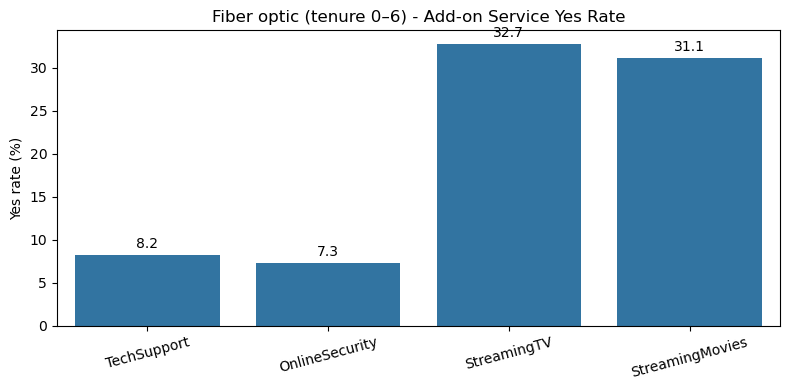

In [62]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=overall_rates, x="Feature", y="YesRate(%)")

ax.set_title("Fiber optic (tenure 0–6) - Add-on Service Yes Rate")
ax.set_xlabel("")
ax.set_ylabel("Yes rate (%)")

# ✅ 막대 위에 숫자 라벨
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=3)

plt.xticks(rotation=15)
plt.tight_layout()

=> 단기 Fiber 고객의 이탈을 계약 유지로 전환하기 위해서 스트리밍 서비스 품질 향상 &

스트리밍 혜택 단독보다 TechSupport/품질 보장과 결합하여 어필해야 함

1. 단기 계약 고객이 1년 이상 장기 계약으로 전환 시 
월 요금의 10~15% 할인 혜택을 제공하여 가격 경쟁력 확보

2. 장기 계약 전환 고객에게 OnlineSecurity 또는 TechSupport 서비스를 
계약 기간 동안 무료로 제공하여 서비스 가치 증대